In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import qutip as qtip
from tqdm  import tqdm
from scipy.ndimage import uniform_filter

from Fit_Routines_Examples import *

_u = 1e6
_G = 1e-9


In [259]:
VNA_power = np.load(path_to_arrays+"VNA_power_{}.npy".format(ExpName))
S21 = np.load(path_to_arrays+"S21_{}.npy".format(ExpName))
freq_list = np.load(path_to_arrays+"freq_{}.npy".format(ExpName))


S21 = np.transpose(S21)

S21_avg = uniform_filter(S21, size=2)

# S21 = S21 - S21_avg

S21_angle = np.unwrap(np.angle(S21))
S21_abs = np.abs(S21)
freq_list *= _G

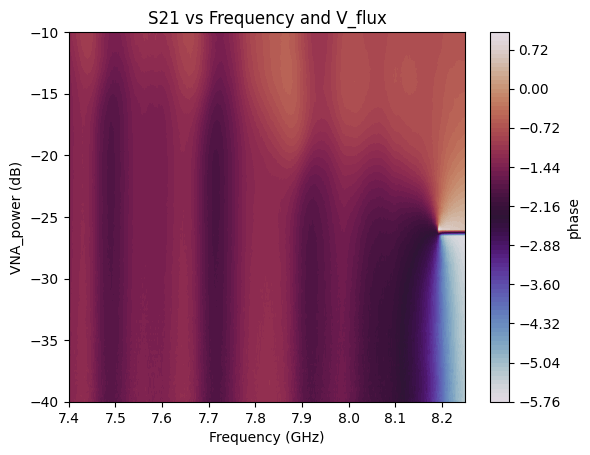

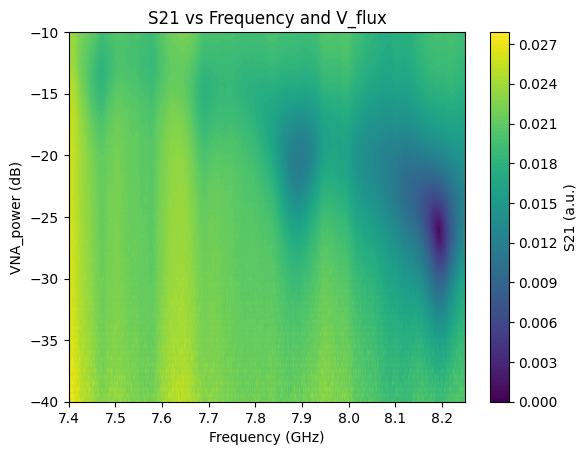

In [260]:

freq_grid, VNA_power_grid = np.meshgrid(freq_list, VNA_power)

plt.contourf(freq_grid, VNA_power_grid, S21_angle, levels=100, cmap='twilight')
plt.colorbar(label='phase')
plt.xlabel('Frequency (GHz)')
plt.ylabel('VNA_power (dB)')
plt.title('S21 vs Frequency and V_flux')
plt.show()


plt.contourf(freq_grid, VNA_power_grid, S21_abs, levels=100, cmap='viridis')
plt.colorbar(label='S21 (a.u.)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('VNA_power (dB)')
plt.title('S21 vs Frequency and V_flux')
plt.show()

VNA power -28.0 dBm


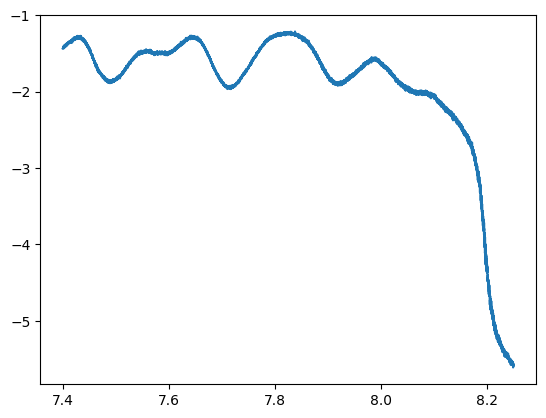

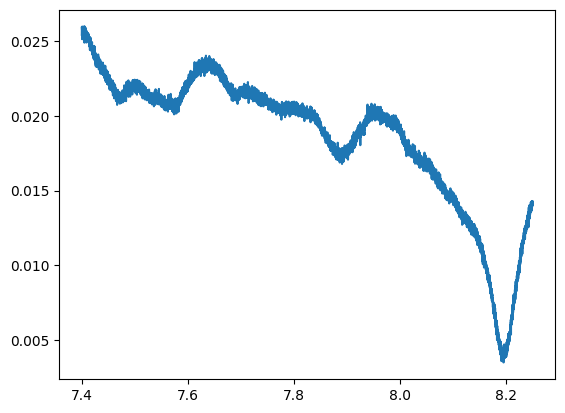

In [221]:
VNA_power_list_idx = -25
print(f"VNA power {VNA_power[VNA_power_list_idx]} dBm")

plt.plot(freq_list, S21_angle[VNA_power_list_idx])
plt.show()

plt.plot(freq_list, S21_abs[VNA_power_list_idx])
plt.show()

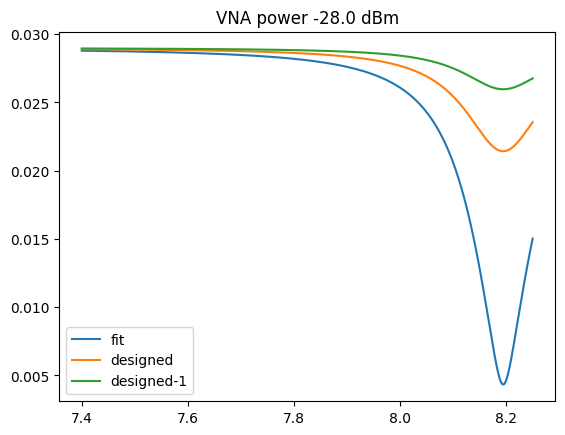

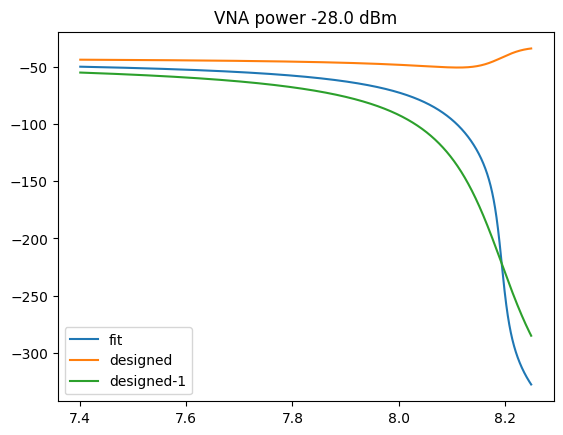

In [253]:
def resonace_dip(freq, freq_r=6.99, Chi = 200,kappa_ext = 90,kappa_int = 5,kappa_phi = 0,coef_F_Chi=0.009,power_coef=0.03):
    

    def find_m(Δ, Ω, offset=0):
        return np.rint( (Δ+offset)/Ω)

    # @jit
    def find_ss_approx(params, offset=0):
        κ, κ_ϕ, Δ, F, χ = params
        H = Δ* a.dag()*a  + χ * a.dag()*a.dag()*a*a + F*(a.dag()+a)
        
        # c_ops = [np.sqrt(κ)*a, np.sqrt(κ_ϕ)*a.dag()*a]
        c_ops = [np.sqrt(κ)*a, np.sqrt(κ_ϕ)*a.dag()*a]

        return qtip.steadystate(H, c_ops)

    def find_num_approx(params, offset=0):
        ss = find_ss_approx(params, offset)
        return qtip.expect(ss, a.dag()*a)

    def find_a_approx(params, offset=0):
        ss = find_ss_approx(params, offset)
        return qtip.expect(ss, a)

    def find_num_S21_a(params, kappa_c, offset=0, coupling='notch'):
        ss = find_ss_approx(params, offset)
        num = qtip.expect(ss, a.dag()*a)
        a_exp = qtip.expect(ss, a)
        κ,κ_ϕ, Δ, F, χ = params
        
        if coupling == 'notch':
            S21 = 1 - 1j*kappa_c/2 * a_exp / F
        elif coupling == 'reflection':
            S21 = 1 - 1j*kappa_c * a_exp / F

        return np.abs(S21)
        return num, a_exp, S21

    coupling = 'reflection'

    kappa_tot = kappa_ext + kappa_int
    F = abs(Chi*coef_F_Chi)

    N_cutoff = 5
    a = qtip.destroy(N_cutoff)

    S21_list = []
    
    Delta_list = (freq - freq_r) # this can be list
    Delta_list = np.array(Delta_list).reshape(1, -1).flatten()
    Delta_list *= 1e3 # GHz to MHz

    lambda_find_num_S21_a = lambda Delta: find_num_S21_a([kappa_tot, kappa_phi, Delta, F, Chi], kappa_ext, coupling=coupling)

    try:
        S21_list = np.asarray(list(map(lambda_find_num_S21_a, Delta_list)))
    except Exception:
        print("Smth went wrong. S21=[0,...,0]")
        S21_list = np.zeros_like(freq)

    return S21_list*power_coef

S21_lambda = lambda w, w_r=6.99, k_tot=(90+5)*1e-3, k_ext=90*1e-3, amp=0.03, alpha=0, phi=0: S21_linear_general(w, w_r=w_r, k_tot=k_tot, k_ext=k_ext, amp=amp, alpha=alpha, phi=phi, config='reflection')

S21_amp_lambda = lambda w, *coefs: np.abs(S21_lambda(w, *coefs))

S21_phase_lambda = lambda w, *coefs: -np.unwrap(np.angle(S21_lambda(w, *coefs)))

# plt.plot(freq_list, resonace_dip(freq_list))
plt.title(f"VNA power {VNA_power[VNA_power_list_idx]} dBm")
plt.plot(freq_list, S21_amp_lambda(freq_list, *[8.19446469,  0.19145136,  0.11003407,  0.02898715, -0.73378565,0.   ]), label="fit")
plt.plot(freq_list, S21_amp_lambda(freq_list, *[8.19446469,  0.19145136,  0.025,  0.02898715, -0.73378565,0.   ]), label='designed')
plt.plot(freq_list, S21_amp_lambda(freq_list, *[8.19446469,  0.19145136,  0.18145136,  0.02898715, -0.73378565,0.   ]), label='designed-1')
plt.legend()
plt.show()


plt.title(f"VNA power {VNA_power[VNA_power_list_idx]} dBm")

plt.plot(freq_list, 180/np.pi*S21_phase_lambda(freq_list, *[8.19446469,  0.19145136,  0.11003407,  0.02898715, -0.73378565,0.   ]), label="fit")
plt.plot(freq_list, 180/np.pi*S21_phase_lambda(freq_list, *[8.19446469,  0.19145136,  0.025,  0.02898715, -0.73378565,0.   ]), label='designed')
plt.plot(freq_list, 180/np.pi*S21_phase_lambda(freq_list, *[8.19446469,  0.19145136,  0.18145136,  0.02898715, -0.73378565,0.   ]), label='designed-1')
plt.legend()
plt.show()



In [236]:
best_candidates[0]

array([ 8.19446469,  0.19145136,  0.11003407,  0.02898715, -0.73378565,
        0.        ])

In [223]:
import numpy as np
from scipy.optimize import curve_fit, minimize
from tqdm import tqdm
def multi_start_optimization(f_list, balance_f, xdata_list, ydata_list, initial_params, sigma, N, M, L, bounds=None):
    """
    Runs the optimization M times for each of the N Gaussian-distributed initial parameter samples,
    and selects the top L candidates based on the residual sum of squares (RSS) for multiple functions.
    
    Parameters:
    - f_list: List of functions to fit.
    - xdata_list: List of independent variable data corresponding to each function.
    - ydata_list: List of dependent variable data corresponding to each function.
    - initial_params: Initial guesses for the parameters (shared by all functions).
    - sigma: Standard deviation for each parameter to generate samples.
    - N: Number of initial parameter sets (samples) to generate.
    - M: Number of optimizations to run per sample.
    - L: Number of best-fitting candidates to select.
    - bounds: Optional bounds for parameters (default is None).
    
    Returns:
    - best_candidates: List of L best candidates with optimized parameters.
    - rss_list: Residual sum of squares for the L best candidates.
    """

    def generate_initial_guesses(initial_params, sigma, N, bounds):
        param_samples = []
        for _ in range(N):
            sample = np.array(initial_params) + np.random.normal(0, sigma, len(initial_params))
            
            if bounds is not None:
                for i, piece in enumerate(sample):
                    sample[i] = np.clip(piece, bounds[0][i], bounds[1][i])

            param_samples.append(sample)
        return param_samples

    def combined_residuals(params, f_list, balance_f, xdata_list, ydata_list):
        total_rss = 0
        for f, bal_f, xdata, ydata in zip(f_list, balance_f, xdata_list, ydata_list):
            residuals = ydata - f(xdata, *params)
            total_rss += bal_f*np.sum(residuals ** 2)
        return total_rss

    param_samples = generate_initial_guesses(initial_params, sigma, N, bounds)
    best_candidates = []

    for sample_idx, sample in enumerate(tqdm(param_samples)):
        for attempt in range(M):
            # if True:
            try:
                result = minimize(combined_residuals, sample, args=(f_list, balance_f, xdata_list, ydata_list), bounds=bounds.T)
                # if result.success:
                popt = result.x
                rss = combined_residuals(popt, f_list, balance_f, xdata_list, ydata_list)
                best_candidates.append((popt, rss))
            except Exception as e:
                print(f"Sample {sample_idx}, attempt {attempt}: Failed with error: {e}")

    # Sort candidates based on RSS (lower RSS is better)
    best_candidates.sort(key=lambda x: x[1])
    
    rss_list = None
    # Select the top L candidates if available
    if len(best_candidates) > 0:
        best_candidates = best_candidates[:min(L, len(best_candidates))]
        rss_list = [rss for _, rss in best_candidates]

    # Return only the optimized parameters and their RSS values
    return [popt for popt, _ in best_candidates], rss_list



In [224]:
# result = fit_res_linear_lmfit(xdata, ydata, config='reflection', guess=[6.99, (90+5)*1e-3, 90*1e-3, 0.03, 0, 0])

In [225]:
# result

In [226]:
initial_params = [8.2, # freq_r
                 (90+5)*1e-3, # kappa tot
                90*1e-3, # kappa_ext
                0.03, # amp
                 0, # ALPHA
                0.0] #phi=

sigma = list(np.array(initial_params)/3)
bounds= np.asarray([[8.1, 0, 0, 0, -np.pi, -np.pi], [8.3, 1000*1e-3, 1000*1e-3, 0.5, np.pi, np.pi]])

N = 100  # Number of initial parameter sets
M = 3   # Number of optimization attempts per parameter set
L = 1   # Number of best candidates to select

# Run the multi-start optimization
# best_candidates, rss_list = multi_start_optimization(S21_amp_lambda, freq_list[np.where(freq_list > 8.0)],
#                                                                       S21_abs[VNA_power_list_idx][np.where(freq_list > 8.0)], initial_params, sigma, N, M, L, bounds=bounds)

# best_candidates, rss_list = multi_start_optimization(S21_phase_lambda, freq_list[np.where(freq_list > 8.0)],
#                                                                       S21_angle[VNA_power_list_idx][np.where(freq_list > 8.0)], initial_params, sigma, N, M, L, bounds=bounds)

lower_freq_cut = 8.17
upper_freq_cut = 100.0
indices = np.where((freq_list >= lower_freq_cut)&(freq_list <= upper_freq_cut))

best_candidates, rss_list = multi_start_optimization([S21_amp_lambda, S21_phase_lambda],
                                                     [1, 0.00001],
                                                     [freq_list[indices], freq_list[indices]],
                                                     [S21_abs[VNA_power_list_idx][indices], S21_angle[VNA_power_list_idx][indices] ],
                                                      initial_params, sigma, N, M, L, bounds=bounds)




print(f"VNA power {VNA_power[VNA_power_list_idx]} dBm")
# Display the results
if best_candidates:
    print("Best Candidates (parameters):")
    print(list(map(float, best_candidates[0])))
    print("Residual Sum of Squares (RSS) for Best Candidates:", rss_list)
else:
    print("No valid candidates found.")

100%|██████████| 100/100 [00:12<00:00,  7.69it/s]

VNA power -28.0 dBm
Best Candidates (parameters):
[8.194464687324333, 0.1914513633721143, 0.11003407256303335, 0.028987150340631408, -0.7337856481349792, 0.0]
Residual Sum of Squares (RSS) for Best Candidates: [np.float64(0.0001691215575259307)]


In [227]:
print(list(map(float, best_candidates[0])))

[8.194464687324333, 0.1914513633721143, 0.11003407256303335, 0.028987150340631408, -0.7337856481349792, 0.0]


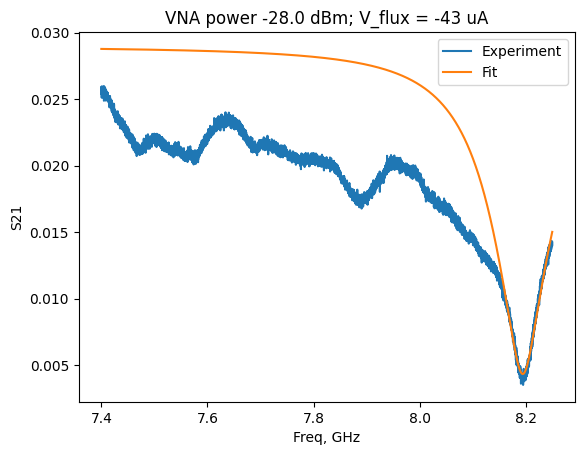

In [231]:
plt.title(f"VNA power {VNA_power[VNA_power_list_idx]} dBm; V_flux = -43 uA")
plt.plot(freq_list, S21_abs[VNA_power_list_idx], label="Experiment")
plt.plot(freq_list, S21_amp_lambda(freq_list, *best_candidates[0]), label="Fit")

plt.xlabel("Freq, GHz")
plt.ylabel("S21")
plt.legend()
plt.show()

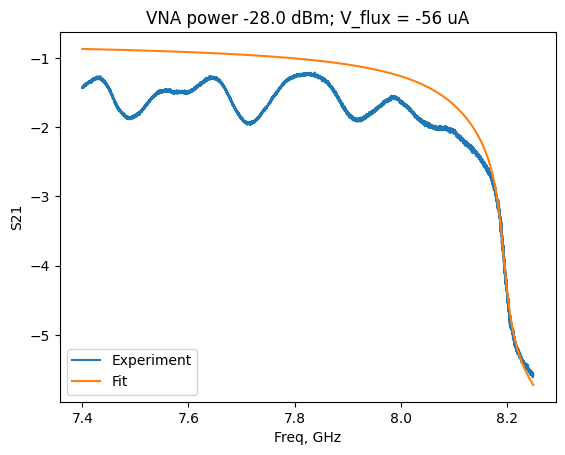

In [229]:
plt.title(f"VNA power {VNA_power[VNA_power_list_idx]} dBm; V_flux = -56 uA")
plt.plot(freq_list, S21_angle[VNA_power_list_idx], label="Experiment")
plt.plot(freq_list, S21_phase_lambda(freq_list, *best_candidates[0]), label="Fit")

plt.xlabel("Freq, GHz")
plt.ylabel("S21")
plt.legend()
plt.show()

In [230]:
print(f"VNA power {VNA_power[VNA_power_list_idx]} dBm")
print(f"freq_r={best_candidates[0][0]} GHz")
print(f"kappa tot={best_candidates[0][1]} MHz")
print(f"kappa ext={best_candidates[0][2]} MHz")
print(f"amp={best_candidates[0][3]} a.u.")
print(f"alpha={best_candidates[0][4]} rad")
print(f"phi={best_candidates[0][5]} rad") #

VNA power -28.0 dBm
freq_r=8.194464687324333 GHz
kappa tot=0.1914513633721143 MHz
kappa ext=0.11003407256303335 MHz
amp=0.028987150340631408 a.u.
alpha=-0.7337856481349792 rad
phi=0.0 rad
